In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

from utils import load_mnist, minibatches
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()

In [74]:
import torch
from torch import nn
from torch.autograd import Variable

class View(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(*self.shape)
    

class AutoEncoder(torch.nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            View(-1, 5 ** 2 * 16),
            nn.Linear(5 ** 2 * 16, 30),
            nn.ReLU(),
            nn.Linear(30, dim),
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(dim, 30),
            nn.ReLU(),
            nn.Linear(30, 5 ** 2 * 16),
            nn.ReLU(),
            View(-1, 16, 5, 5),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(16, 8, 4),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(8, 1, 3),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

net = AutoEncoder(dim=10).cuda()
criterion = torch.nn.BCELoss()
losses = []

In [86]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [87]:
epochs = 30
batch_size = 1000
freq = 2000 / batch_size

In [88]:
for epoch in range(epochs):
    ep = 'Epoch %d: ' % epoch
    mean_loss = 0
    step = 0
    bar = tqdm(minibatches(X_train, y_train, batch_size=batch_size), leave=False, 
               total=(epochs-epoch) * len(X_train) // batch_size)
    for x, _ in bar:
        x = Variable(torch.from_numpy(x)).cuda()

        y_pred = net(x)
        loss = criterion(y_pred, x)
        mean_loss += loss.cpu().data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(ep + str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(ep + str(losses[-1]))

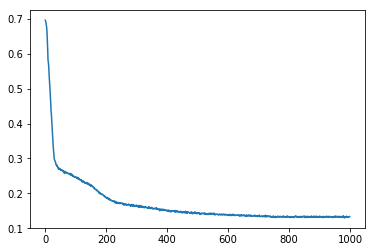

In [90]:
plt.plot(losses)

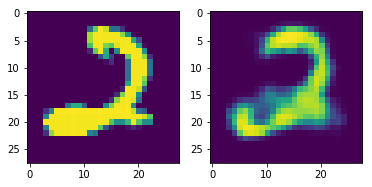

In [92]:
x = X_train[[1010]]
y = net(Variable(torch.from_numpy(x)).cuda()).cpu().data.numpy()
ax = plt.subplots(1, 2)[1]
ax[0].imshow(x[0][0], interpolation='none')
ax[1].imshow(y[0][0], interpolation='none')